# Grupo: Fabio Grassiotto, Euline Marcos Rodrigues, Luis Antônio Prado
# Disciplina: IA369Y, 2ºS 2017
# Projeto: Emoções em Bolsas de Valores

O objetivo deste projeto foi procurar relacionar a valência das notícias relativas ao mercado financeiro à flutuação de valor das ações na bolsa.

As idéias que seguimos neste projeto foram:
- A partir da coleta de mensagens do twitter ou sites de notícias verificar o impacto no mercado de ações
- Restringir ao mercado americano, devido as APIs e corpus disponíveis
- Somente empresas de tecnologia com ações na NASDAQ
- Descobrir se realmente existe correlação



## 1. Seleção das empresas de tecnologia

Selecionamos as 10 empresas negociadas na bolsa de Nova Iorque com a maior valor de mercado:

- Apple
- Google
- Microsoft
- Facebook
- Taiwan Semiconductor (a maior fábrica de semicondutores do mundo)
- Cisco
- Intel
- Oracle
- IBM
- SAP

## 2. Obtenção das notícias relacionadas às empresas

A primeira dificuldade encontrada foi obter as notícias de tecnologia relacionadas às empresas acima. As principais APIs utilizadas para esse propósito (Google Finance e Yahoo) não estão mais em operação. 
Felizmente, o site Intrinio oferece uma API que permite a extração de notícias históricas com seleção por empresa.

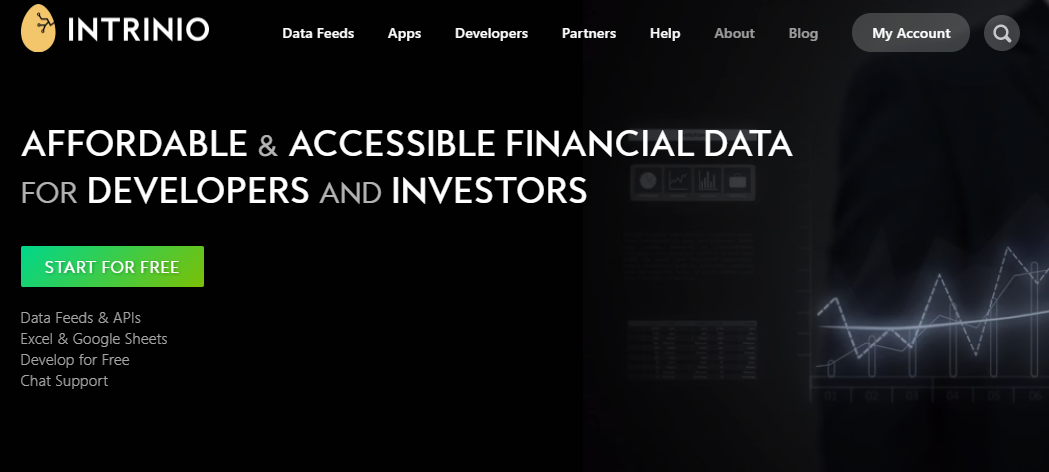

In [1]:
from IPython.display import Image
Image("images/intrinio-site.png")

Utilizando o código abaixo, as notícias foram extraídas e gravadas em arquivos CSV, um por empresa, para processamento posterior.

```
# %load intrinio-fetch.py
# Script para extrair dados de notícias do site intrinio
# das 10 ações de tecnologia com maor Market Cap negociadas na NASDAQ.
import intrinio

# O site intrinio fornece acesso à API através de username e senha
# a API tem limites de utilização diária, por isso duas contas foram utilizadas
# para executar o fetch.
#intrinio.client.username = 'cbf3647ca29bd2236958b388b875b9fd'
#intrinio.client.password = '932441d13c084642d3bfece69acb1227'

intrinio.client.username = '9ef28500250f001837e864630f98010d'
intrinio.client.password = 'b6d38989841c00d252232a7ef1822f20'

# Extrai notícias em dataframe pandas e grava em CSV.
df_appl = intrinio.news('AAPL')
df_appl.to_csv('news/AAPL.csv')
df_googl = intrinio.news('GOOGL')
df_googl.to_csv('news/GOOGL.csv')
df_msft = intrinio.news('MSFT')
df_msft.to_csv('news/MSFT.csv')
df_fb = intrinio.news('FB')
df_fb.to_csv('news/FB.csv')
df_tsm = intrinio.news('TSM')
df_tsm.to_csv('news/TSM.csv')
df_csco = intrinio.news('CSCO')
df_csco.to_csv('news/CSCO.csv')
df_intc = intrinio.news('INTC')
df_intc.to_csv('news/INTC.csv')
df_orcl = intrinio.news('ORCL')
df_orcl.to_csv('news/ORCL.csv')
df_ibm = intrinio.news('IBM')
df_ibm.to_csv('news/IBM.csv')
df_sap = intrinio.news('SAP')
df_sap.to_csv('news/SAP.csv')
```

O resultado da execução do código pode ser visualizado para a empresa AAPL. Apenas as coluna com o título da notícia e data de publicação foram selecionadas abaixo para visualização. 

In [2]:
import pandas as pd
df = pd.read_csv('news\AAPL.csv')
df = df [['title', 'publication_date']]
pd.set_option('display.max_rows', 10)
df

,title,publication_date
0,Israeli start-up says Apple copied its patente...,2017-11-07 22:32:13 +0000
1,Israeli start-up says Apple copied its patente...,2017-11-07 22:31:40 +0000
2,Here’s how much the iPhone X costs Apple to make,2017-11-07 22:14:28 +0000
3,"Here&apos;s How Much Debt Apple, Inc. Ended Up...",2017-11-07 22:00:00 +0000
4,"iPhone X Teardowns, Drop Tests Revealed Flawed...",2017-11-07 21:30:00 +0000
...,...,...
28934,Apple plans to sell $1 bln of 30-yr bonds in T...,2016-06-01 08:29:12 +0000
28935,India discussing Apple's request for FDI rules...,2016-05-30 17:05:39 +0000
28936,India says Apple must sell locally-sourced goo...,2016-05-25 17:48:27 +0000
28937,More challenges than cheer for Apple chief on ...,2016-05-24 08:42:12 +0000


Pode-se notar que a quantidade de notícias retornada é muito grande, com cerca de 30000 para a Apple. Algumas notícias são duplicadas, provavelmente por causa de sindicalização no mercado editorial digital.
Para resolver o problema de duplicação e agregar todas as notícias em um banco de dados para classificação, o código abaixo foi executado criando um banco de dados no arquivo __news.db__.

In [3]:
# %load create-newsdb.py
# Script para criar um banco de dados sql-lite com as notícias relativas
# às ações de tecnologia.

import glob
import os
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import MetaData

if os.path.exists('news.db'):
    os.remove('news.db')

news_files = glob.glob('news/*.csv')

# Conexão com db
disk_engine = create_engine('sqlite:///news.db')

for file in news_files:
    df = pd.read_csv(file)
    df = df[['ticker', 'publication_date', 'title']]
    # Remove entradas duplicadas
    df = df.drop_duplicates(subset='title', keep="last")
    df.to_sql('news_table', disk_engine, if_exists='append')

m = MetaData()
m.reflect(disk_engine)
print('News Database:')
for table in m.tables.values():
    print("Tabela: {0}".format(table.name))
    print("Colunas:")
    for column in table.c:
        print(column.name)
    

News Database:
Tabela: news_table
Colunas:
index
ticker
publication_date
title


## 3. Obtenção dos valores de ações na Nasdaq

--> Luisinho, pode colocar aqui como vc fez por favor?

## 4. Execução da classificação do sentimento das notícias

O sentimento das notícias foi então classificado utilizando três bases de dados diferentes:

1. Sentiwordnet
2. Afinn
3. Base da biblioteca TextBlob

Para a classificação, foi utilizado o classificador Multinomial de Bayes da biblioteca Scikit-Learn, que é conhecido por ter boa performance na classificação multi-classe de textos.

### 4.1 Sentiwordnet

A base Sentiwordnet tem cerca de 120 mil termos, com classificação de valência positiva e negativa.

```
ID         PosScore  NegScore    SynsetTerms  label
0          0.125     0.000           able      1
1          0.000     0.750         unable     -7
2          0.000     0.000         dorsal      0
3          0.000     0.000        ventral      0
4          0.000     0.000     acroscopic      0
....
117652     0.000     0.250         plague     -2
117653     0.000     0.000          swamp      0
117654     0.000     0.000        run_dry      0
117655     0.000     0.125         fog_up     -1
117656     0.000     0.000           coal      0
117657     0.125     0.250           haze     -1
117658     0.125     0.000     deflagrate      1
```

Para classificação, foram criadas classes de valências obtidas a partir da subtração da valência negativa da positiva e multiplicada por 10, obtendo a seguinte distribuição:

```
Classe  Qty
 0     89805
 1      5145
-1      4704
 2      3242
-2      3139
-3      2137
 3      1982
-5      1963
-6      1586
 5      1508
-7       935
 6       791
 7       325
-8       246
 8       116
 10       19
-10       16
```
Pode-se notar que a maior parte dos termos no corpus classifica as palavras como neutras, o que vai gerar uma distribuição similar na classificação das notícias.
Executando o classificador obtemos abaixo:

In [4]:
# %load classify-senti.py
# Script para executar classificação das manchetes relacionadas a ações.
# Base: Sentiwordnet 3.0
import pandas as pd
import nltk
import re
from pandas import DataFrame
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sqlalchemy import create_engine

# Transforma scores positivos/negativos em valência
def create_label(row):
    return int(10*(row['PosScore'] - row['NegScore']))

# Stemming
def stem_tokens(tokens, stemmer):
    stemmed = [stemmer.stem(item) for item in tokens]
    return(stemmed)

# Tokenização
def tokenize(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return(stems)

# Leitura do sentiwordnet 3.0 em um dataframe e manipulação dos dados.
# Após a manipulação ficamos com as colunas na tabela: Pos Neg Word
df = pd.read_csv('SentiWordNet_3.0.0_20130122.txt', comment = '#', sep='\t')
df.drop(df.columns[[0, 1, 5]], axis=1, inplace=True)
df.drop(df.tail(1).index,inplace=True)

# Processamento do wordnet para obter um label único para cada palavra...
df['label'] = df.apply (lambda row: create_label (row),axis=1)

# Test Data
engine = create_engine('sqlite:///news.db')
table_name = 'news_table'
test_df = pd.read_sql_table(table_name, engine)

stemmer = PorterStemmer()

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    stop_words = 'english'
)

train_data = df['SynsetTerms']
train_labels = df['label']
test_data = test_df['title']

train_vectors = vectorizer.fit_transform(train_data.values.astype('U'))
test_vectors = vectorizer.transform(test_data.values.astype('U'))

# Classificação
classifier = MultinomialNB(alpha=0.01)
classifier.fit(train_vectors, train_labels)
prediction = classifier.predict(test_vectors)
probabilities = classifier.predict_proba(test_vectors)

# Output
s = pd.Series(prediction)
print(s.value_counts())

test_df['valence'] = prediction  

# Escreve a classificação no banco de dados.
test_df = test_df.drop('index', axis = 1)
test_df.to_sql('news_table', engine, if_exists='replace')

 0     80371
 1      5163
 5      1379
-1       831
 3       677
       ...  
 8        65
-8        55
-7        53
 10        6
-10        1
Length: 17, dtype: int64


Plotando os gráficos de comparação dos valores de ações e sentimento, obtemos abaixo:

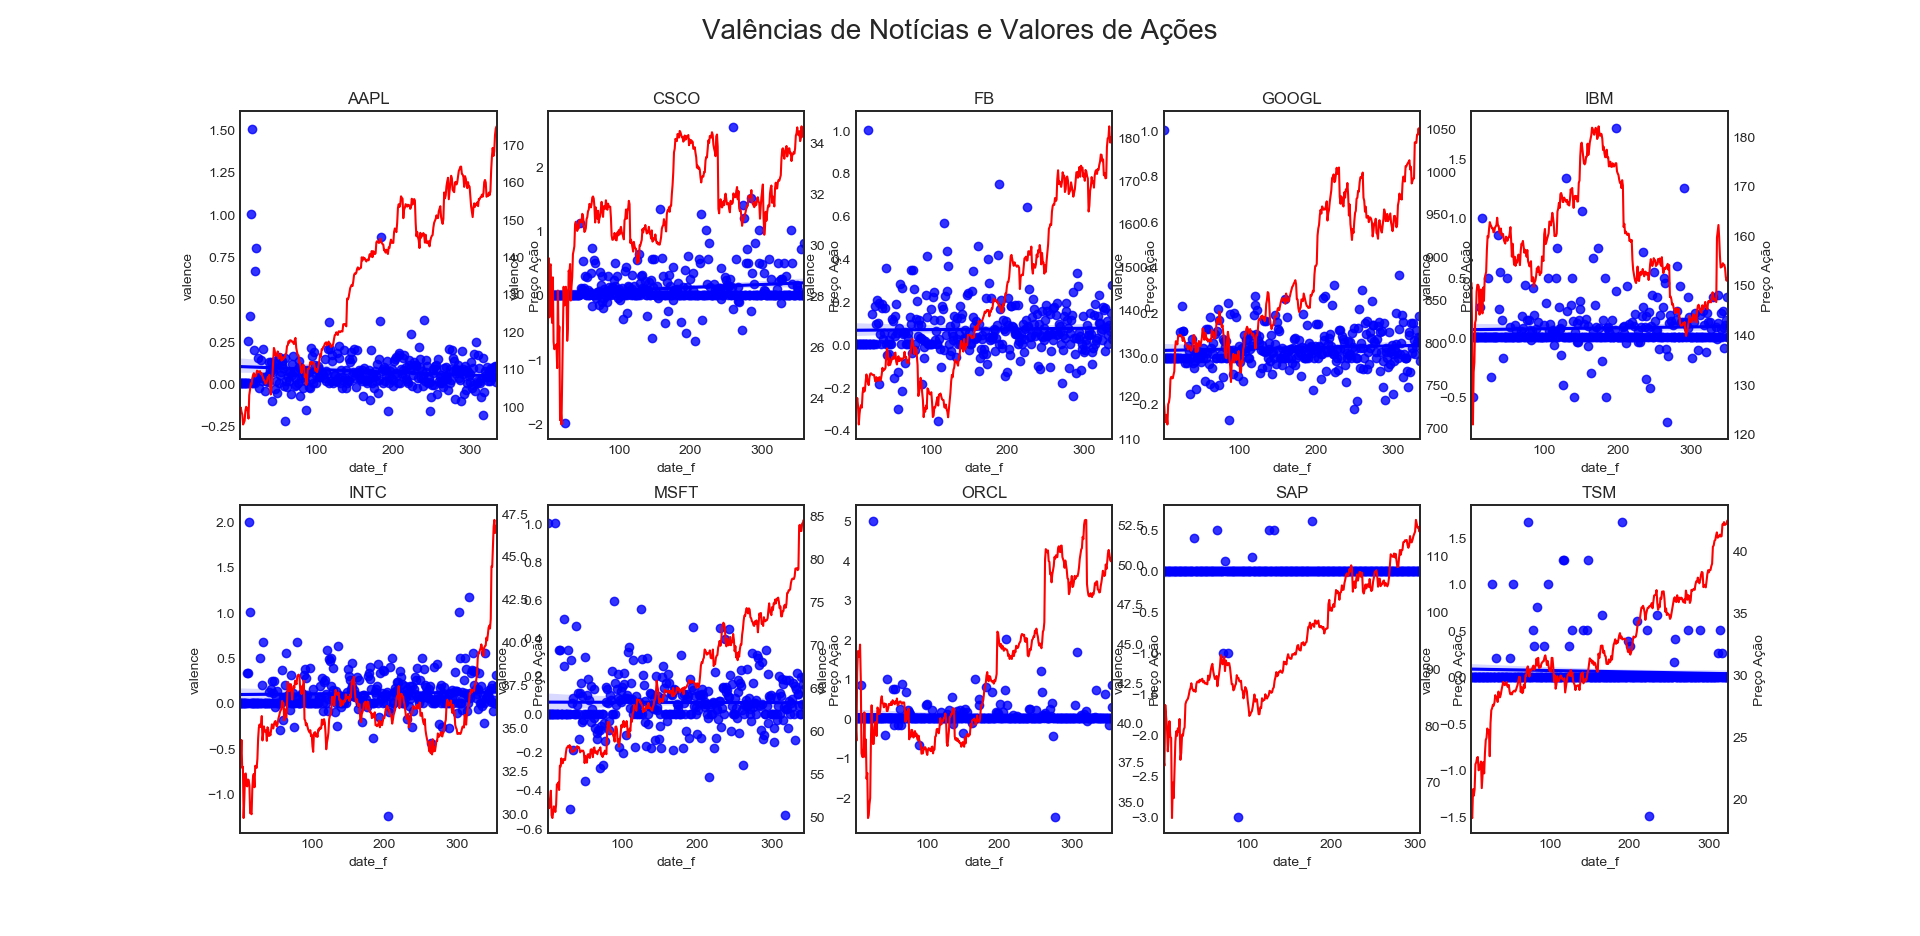

In [5]:
from IPython.display import Image
Image("plots/senti/val-stocks.png")

Se restringirmos mais o horizonte de tempo de análise, com notícias desde 15 de setembro de 2017, obtemos:

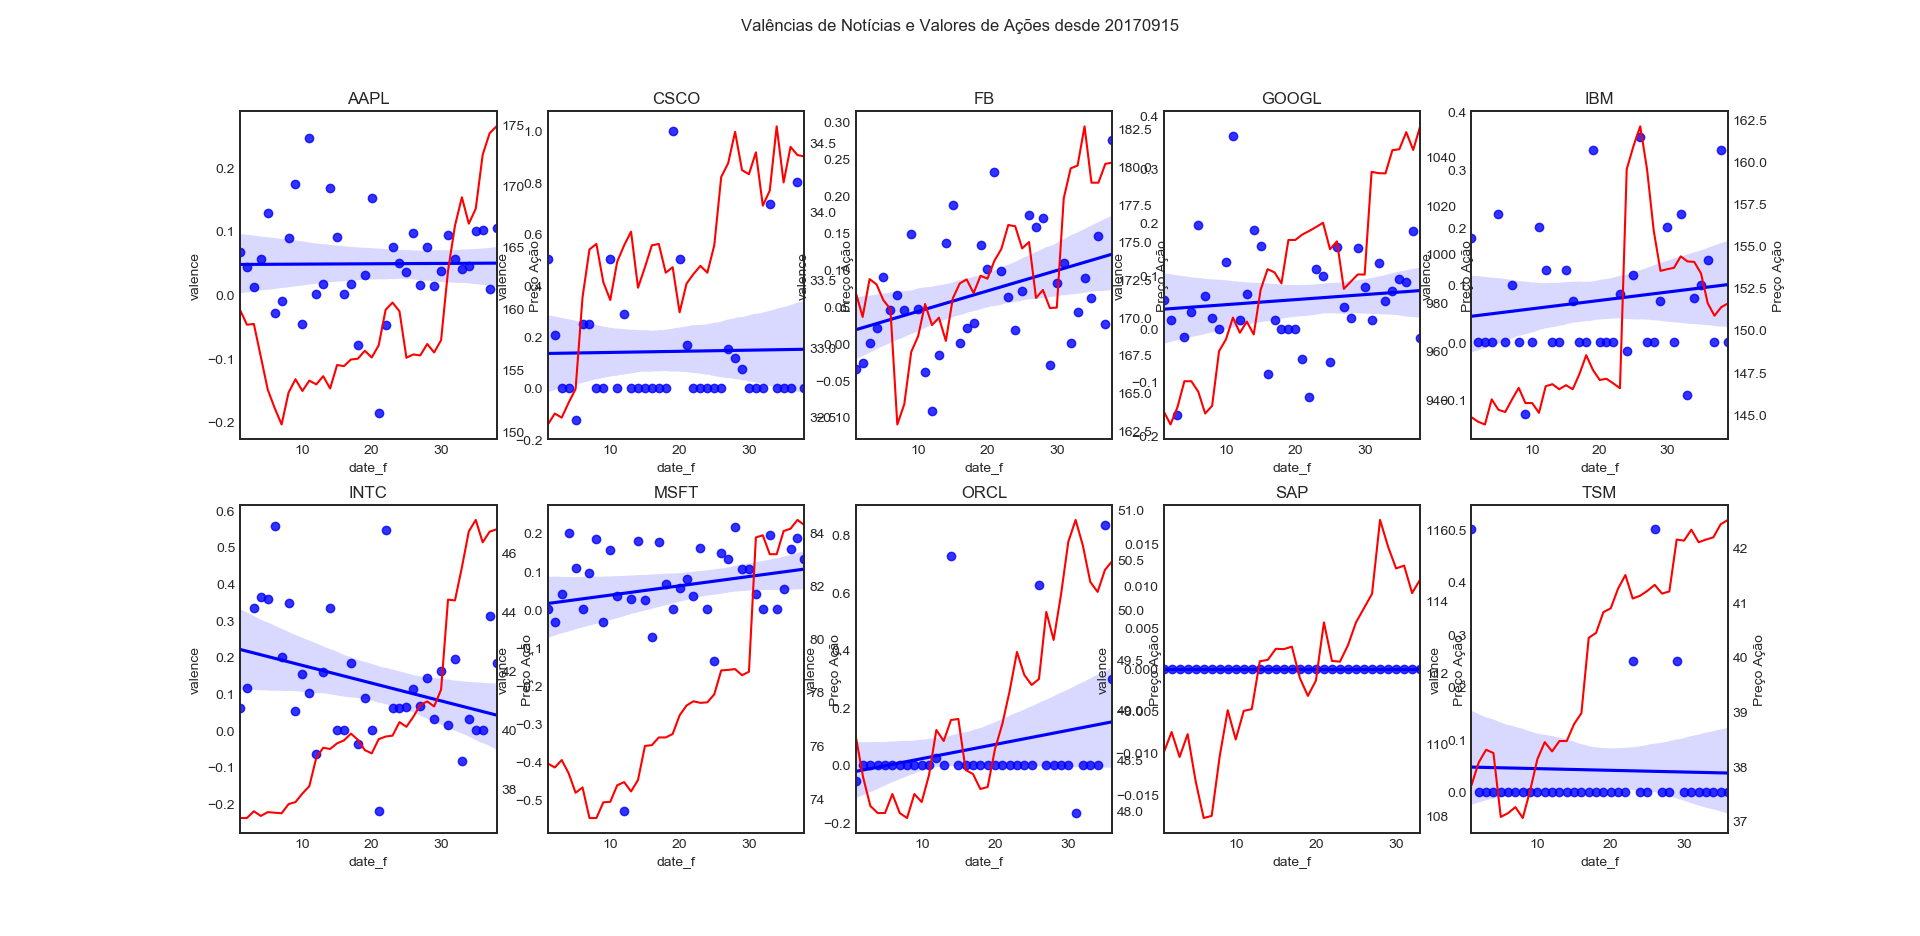

In [7]:
from IPython.display import Image
Image("plots/senti/val-stocks-20170915.png")

Podemos notar que para este classificador a correlação pode ser apenas observada para 5 das 10 ações, e apenas no horizonte de tempo mais curto.